In [1]:
# Data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: Model selection & evaluation
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    train_test_split,
    GridSearchCV
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score
)

# Scikit-learn: Feature selection & preprocessing
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    SelectFromModel,
    f_classif
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Scikit-learn: Models & pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone

# Statsmodels: VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor


## Load data

In [2]:
data = pd.read_parquet("../Data/stylo_embedds.parquet")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 208 entries, Author to lex_MarkerCount
dtypes: float64(195), int64(12), object(1)
memory usage: 6.1+ MB


In [4]:
# Devide features and target variable, scale features

y = data['Author']
X = data.drop(columns=['Author'])

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Columns: 207 entries, lex_WordCount to lex_MarkerCount
dtypes: float64(207)
memory usage: 6.1 MB


## Feature selection part 1 : upper bound

### Determining the final number of features to select

In [6]:
# Helper function to compute VIF
def calculate_vif(X, thresh=10):
    X_df = pd.DataFrame(X)
    dropped = True
    while dropped:
        dropped = False
        vif = pd.Series(
            [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])],
            index=X_df.columns,
        )
        if vif.max() > thresh:
            drop_col = vif.idxmax()
            X_df = X_df.drop(columns=[drop_col])
            dropped = True
    return X_df

# Fisher score computation
def fisher_score(X, y):
    F, _ = f_classif(X, y)
    return pd.Series(F, index=X.columns).sort_values(ascending=False)

In [ ]:
def feature_selection_eval(X, y, classifier=None):
    if classifier is None:
        classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    results = []
    current_X = X.copy()
    y = y.reset_index(drop=True)

    def evaluate_and_log(X_stage, stage_name):
        X_train, X_test, y_train, y_test = train_test_split(
            X_stage, y, test_size=0.2, stratify=y, random_state=42
        )
        clf = clone(classifier)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)

        results.append({
            "Stage": stage_name,
            "Num_features": X_stage.shape[1],
            "Macro_F1": f1_score(y_test, y_pred, average='macro'),
            "Balanced_Accuracy": balanced_accuracy_score(y_test, y_pred),
            "Log_Loss": log_loss(y_test, y_proba)
        })

    # 1. Low Variance Filter
    selector = VarianceThreshold(threshold=0.01)
    X_var = pd.DataFrame(selector.fit_transform(current_X), columns=current_X.columns[selector.get_support()])
    evaluate_and_log(X_var, "VarianceThreshold")
    current_X = X_var
    print("Low Variance Filter done")
    
    #2. Mutual Information Filter
    mi_scores = pd.Series(mutual_info_classif(current_X, y, discrete_features=False, random_state=42),
                        index=current_X.columns)
    mi_threshold = mi_scores.quantile(0.05)  # Keep top 95%
    selected_mi = mi_scores[mi_scores > mi_threshold].index
    X_mi = current_X[selected_mi]
    evaluate_and_log(X_mi, "MutualInfoFilter")
    current_X = X_mi
    print("Mutual Information Filter done")

    # 3. Correlation Filter
    corr_matrix = current_X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = []
    for col in upper.columns:
        for row in upper.index:
            if upper.loc[row, col] > 0.9:
                if row not in current_X.columns or col not in current_X.columns:
                    continue
                # Compare MI scores
                if mi_scores[row] >= mi_scores[col]:
                    to_drop.append(col)
                else:
                    to_drop.append(row)

    to_drop = list(set(to_drop))
    X_corr = current_X.drop(columns=to_drop)
    evaluate_and_log(X_corr, "CorrelationFilter")
    current_X = X_corr
    print("Correlation Filter done")

    # 4. VIF Filtering
    X_vif = calculate_vif(current_X, thresh=10)
    evaluate_and_log(X_vif, "VIF_Filter")
    current_X = X_vif
    print("VIF done")

    # 5. L1-based selection with Logistic Regression
    lr = LogisticRegression(penalty='l1', solver='saga', random_state=42)
    lr.fit(current_X, y)
    coef_mask = lr.coef_.sum(axis=0) != 0  # select non-zero coefficients
    X_l1 = current_X.loc[:, coef_mask]
    evaluate_and_log(X_l1, "L1_LogReg")
    current_X = X_l1
    print("L1 penalty done")

    # 6. Fisher Score + Iterative Feature Reduction
    fisher_scores = fisher_score(current_X, y)
    for k in range(current_X.shape[1], 2, -5):  # step down by 5 features
        top_features = fisher_scores.head(k).index
        X_fs = current_X[top_features]
        evaluate_and_log(X_fs, f"FisherTop{k}")
        print(f"Fisher Score top {k} features done")
    
    # Compile results into DataFrame
    results_df = pd.DataFrame(results)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Courbes
    plt.plot(results_df["Num_features"], results_df["Macro_F1"], label="Macro F1", marker='o')
    plt.plot(results_df["Num_features"], results_df["Balanced_Accuracy"], label="Balanced Accuracy", marker='o')
    plt.plot(results_df["Num_features"], results_df["Log_Loss"], label="Log Loss", marker='o')

    # Annotations sur chaque courbe
    for x, y in zip(results_df["Num_features"], results_df["Macro_F1"]):
        plt.annotate(f"{x}", (x, y), textcoords="offset points", xytext=(0, 6), ha='center', fontsize=8, color='blue')

    for x, y in zip(results_df["Num_features"], results_df["Balanced_Accuracy"]):
        plt.annotate(f"{x}", (x, y), textcoords="offset points", xytext=(0, 6), ha='center', fontsize=8, color='orange')

    for x, y in zip(results_df["Num_features"], results_df["Log_Loss"]):
        plt.annotate(f"{x}", (x, y), textcoords="offset points", xytext=(0, 6), ha='center', fontsize=8, color='green')

    # Mise en forme
    plt.xlabel("Number of Features")
    plt.ylabel("Metric Value")
    plt.title("Feature Selection vs Performance Metrics")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results_df


Low Variance Filter done
Mutual Information Filter done
Correlation Filter done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 penalty done
Fisher Score top 170 features done
Fisher Score top 165 features done
Fisher Score top 160 features done
Fisher Score top 155 features done
Fisher Score top 150 features done
Fisher Score top 145 features done
Fisher Score top 140 features done
Fisher Score top 135 features done
Fisher Score top 130 features done
Fisher Score top 125 features done
Fisher Score top 120 features done
Fisher Score top 115 features done
Fisher Score top 110 features done
Fisher Score top 105 features done
Fisher Score top 100 features done
Fisher Score top 95 features done
Fisher Score top 90 features done
Fisher Score top 85 features done
Fisher Score top 80 features done
Fisher Score top 75 features done
Fisher Score top 70 features done
Fisher Score top 65 features done
Fisher Score top 60 features done
Fisher Score top 55 features done
Fisher Score top 50 features done
Fisher Score top 45 features done
Fisher Score top 40 features done
Fisher Score top 35 features done
Fisher Score top 

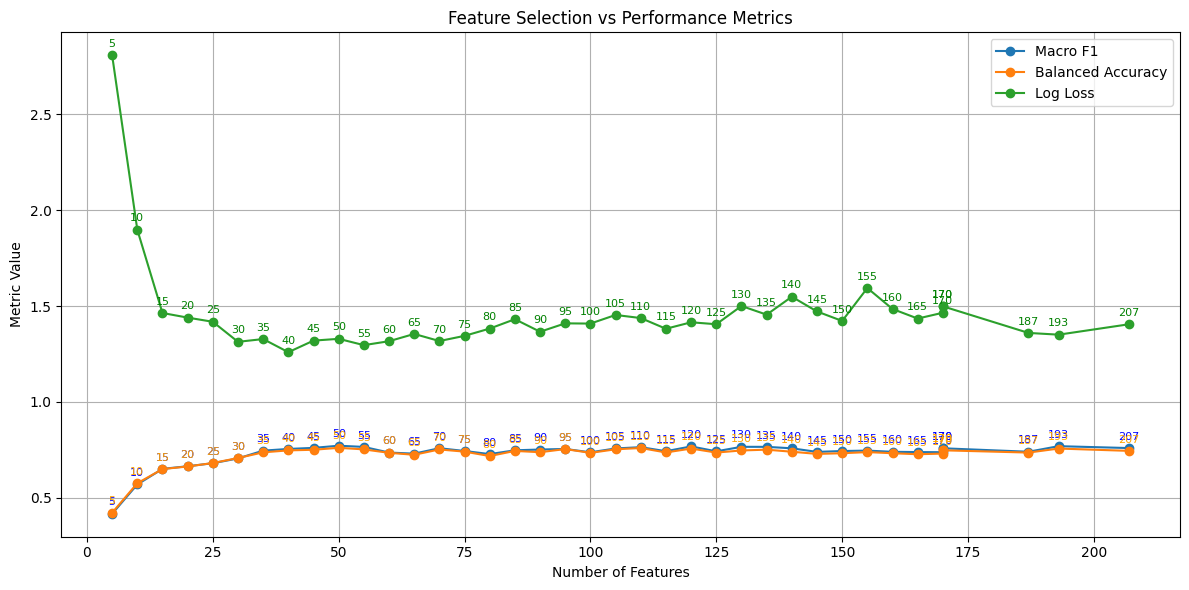

In [8]:
fs_df = feature_selection_eval(X, y)

After 50, performance declines and soon after log loss only increases. For trees, 50 seem like the upper bound

In [9]:
fs2_df = feature_selection_eval(X, y, classifier=LogisticRegression(penalty=None, solver='saga', multi_class="ovr",
                                                                        C=1.0, max_iter=5000, class_weight="balanced", random_state=42))

/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Low Variance Filter done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Mutual Information Filter done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packa

Correlation Filter done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-p

VIF done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 penalty done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fisher Score top 170 features done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fisher Score top 165 features done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fisher Score top 160 features done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fisher Score top 155 features done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fisher Score top 150 features done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fisher Score top 145 features done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fisher Score top 140 features done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fisher Score top 135 features done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Fisher Score top 130 features done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Fisher Score top 125 features done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fisher Score top 120 features done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Fisher Score top 115 features done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fisher Score top 110 features done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fisher Score top 105 features done


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
fs_df.head()

,Stage,Num_features,Macro_F1,Balanced_Accuracy,Log_Loss
0,VarianceThreshold,207,0.759578,0.744950,1.405092
1,CorrelationFilter,201,0.738107,0.736248,1.398567
2,VIF_Filter,184,0.735533,0.732473,1.470166
3,L1_LogReg,184,0.735533,0.732473,1.470166
4,RandomForest_Importance,92,0.742944,0.741304,1.393156


In [ ]:
fs2_df.head()

,Stage,Num_features,Macro_F1,Balanced_Accuracy,Log_Loss
0,VarianceThreshold,207,0.848859,0.847580,0.895598
1,CorrelationFilter,201,0.844072,0.843752,0.918738
2,VIF_Filter,184,0.813563,0.814972,1.018842
3,L1_LogReg,184,0.813563,0.814972,1.018842
4,RandomForest_Importance,92,0.849237,0.849972,0.883207


### Applying feature selection

In [ ]:
def calculate_vif(X, thresh=10):
    X_df = X.copy()
    dropped_features = {}
    dropped = True
    while dropped:
        dropped = False
        vif = pd.Series(
            [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])],
            index=X_df.columns,
        )
        if vif.max() > thresh:
            drop_col = vif.idxmax()
            dropped_features[drop_col] = vif[drop_col]
            X_df = X_df.drop(columns=[drop_col])
            dropped = True
    return X_df, dropped_features

def fisher_score(X, y):
    F, _ = f_classif(X, y)
    return pd.Series(F, index=X.columns)

def extract_categories(feature_names):
    return [name.split('_')[0] if '_' in name else 'uncategorized' for name in feature_names]

def category_summary(feature_list):
    categories = extract_categories(feature_list)
    return pd.Series(categories).value_counts().to_dict()

def feature_selection_pipeline(
    X,
    y,
    var_threshold=0.01,
    mi_percentile=0.05,
    corr_threshold=0.9,
    vif_threshold=10,
    l1_penalty_C=1.0,
    fisher_top_k=50
):
    logs = []  # To store dropped features and category summaries
    current_X = X.copy()
    y = y.reset_index(drop=True)

    def log_step(step_name, old_features, new_X, dropped_info):
        dropped = set(old_features) - set(new_X.columns)
        category_counts = category_summary(new_X.columns)
        log_entry = {
            "Step": step_name,
            "Dropped_Features": dropped_info if dropped_info else {f: None for f in dropped},
            "Remaining_Features": list(new_X.columns),
            "Category_Counts": category_counts
        }
        logs.append(log_entry)
        
    print("Starting feature selection pipeline...")
    print(f"Initial features: {X.shape[1]}")

    # Step 1: Variance Threshold
    selector = VarianceThreshold(threshold=var_threshold)
    selector.fit(current_X)
    kept_columns = current_X.columns[selector.get_support()]
    dropped_info = {col: current_X[col].var() for col in current_X.columns if col not in kept_columns}
    current_X = pd.DataFrame(selector.transform(current_X), columns=kept_columns)
    log_step("VarianceThreshold", X.columns, current_X, dropped_info)
    print(f"Variance Threshold done, current features: {current_X.shape[1]}")
    
    # Step 2: Mutual Information Filter
    mi_scores = pd.Series(
        mutual_info_classif(current_X, y, discrete_features=False, random_state=42),
        index=current_X.columns
    )
    mi_thresh = mi_scores.quantile(mi_percentile)  # Keep features above the bottom percentile
    selected = mi_scores[mi_scores > mi_thresh].index
    dropped_info = mi_scores[~mi_scores.index.isin(selected)].to_dict()
    current_X = current_X[selected]
    log_step("MutualInfoFilter", mi_scores.index.tolist(), current_X, dropped_info)
    print(f"Mutual Information Filter done, current features: {current_X.shape[1]}")

    # Step 3: Correlation Filter
    corr_matrix = current_X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = set()
    for col in upper.columns:
        for row in upper.index:
            if upper.loc[row, col] > corr_threshold and row in current_X.columns and col in current_X.columns:
                if mi_scores.get(row, 0) >= mi_scores.get(col, 0):
                    to_drop.add(col)
                else:
                    to_drop.add(row)

    dropped_info = {f: upper.loc[:, f][upper.loc[:, f] > corr_threshold].max() for f in to_drop}
    current_X = current_X.drop(columns=to_drop)
    log_step("CorrelationFilter", current_X.columns.tolist() + list(to_drop), current_X, dropped_info)
    print(f"Correlation Filter done, current features: {current_X.shape[1]}")

    # Step 4: VIF Filter
    current_X, dropped_info = calculate_vif(current_X, thresh=vif_threshold)
    log_step("VIF_Filter", current_X.columns.tolist() + list(dropped_info.keys()), current_X, dropped_info)
    print(f"VIF Filter done, current features: {current_X.shape[1]}")

    # Step 5: L1 Logistic Regression
    lr = LogisticRegression(penalty='l1', solver='saga', C=l1_penalty_C, random_state=42)
    lr.fit(current_X, y)
    coef_mask = lr.coef_.sum(axis=0) != 0
    selected = current_X.columns[coef_mask]
    dropped_info = {col: 0.0 for col in current_X.columns if col not in selected}
    current_X = current_X[selected]
    log_step("L1_LogReg", current_X.columns.tolist() + list(dropped_info.keys()), current_X, dropped_info)
    print(f"L1 Logistic Regression done, current features: {current_X.shape[1]}")

    # Step 6: Fisher Score
    fisher_scores = fisher_score(current_X, y)
    top_features = fisher_scores.sort_values(ascending=False).head(fisher_top_k).index
    dropped_info = fisher_scores[~fisher_scores.index.isin(top_features)].to_dict()
    current_X = current_X[top_features]
    log_step("FisherScore_TopK", fisher_scores.index.tolist(), current_X, dropped_info)
    print(f"Fisher Score top {fisher_top_k} features done, current features: {current_X.shape[1]}")

    return current_X, logs


In [ ]:
X_temp, logs = feature_selection_pipeline(
    X, y,
    var_threshold=0.01,
    corr_threshold=0.9,
    vif_threshold=10,
    l1_penalty_C=1.0,
    rf_percentile=0.5,
    fisher_top_k=50
)

Starting feature selection pipeline...
Initial features: 207
Variance Threshold done, current features: 207
Correlation Filter done, current features: 201


/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF Filter done, current features: 184
L1 Logistic Regression done, current features: 184
Random Forest feature importance done, current features: 92
Fisher Score top 50 features done, current features: 50


In [ ]:
def summarize_feature_selection_logs(logs, show_dropped_table=False):
    # Track number of features and per-category counts
    step_names = []
    num_features = []
    category_counts = {}

    for entry in logs:
        step = entry["Step"]
        step_names.append(step)
        num_features.append(len(entry["Remaining_Features"]))
        
        for category, count in entry["Category_Counts"].items():
            category_counts.setdefault(category, []).append(count)

        # Fill in 0s for categories not present at this step
        for category in category_counts:
            if len(category_counts[category]) < len(step_names):
                category_counts[category].append(0)

    # Plot: Number of features per step
    plt.figure(figsize=(10, 5))
    plt.plot(step_names, num_features, marker='o', label='Total Features')
    plt.title("Number of Remaining Features at Each Step")
    plt.xlabel("Step")
    plt.ylabel("Number of Features")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot: Category-wise feature count evolution
    plt.figure(figsize=(12, 6))
    for cat, counts in category_counts.items():
        plt.plot(step_names, counts, marker='o', label=cat)
    plt.title("Feature Count per Category by Step")
    plt.xlabel("Step")
    plt.ylabel("Number of Features")
    plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Display dropped features and scores
    if show_dropped_table:
        all_dropped = []
        for entry in logs:
            for feat, score in entry["Dropped_Features"].items():
                all_dropped.append({
                    "Step": entry["Step"],
                    "Feature": feat,
                    "Score": score
                })
        dropped_df = pd.DataFrame(all_dropped)
        dropped_df = dropped_df.sort_values(by=["Step", "Score"], ascending=[True, False])
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            print(dropped_df)


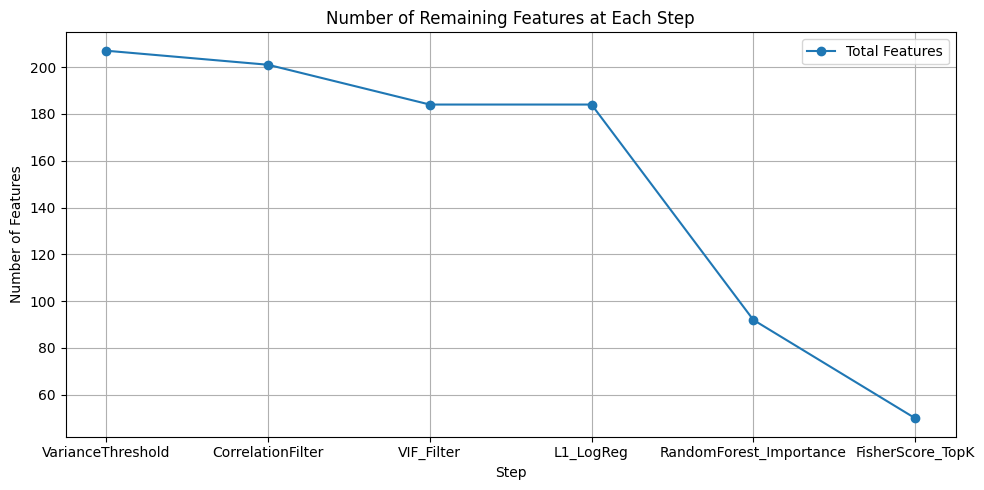

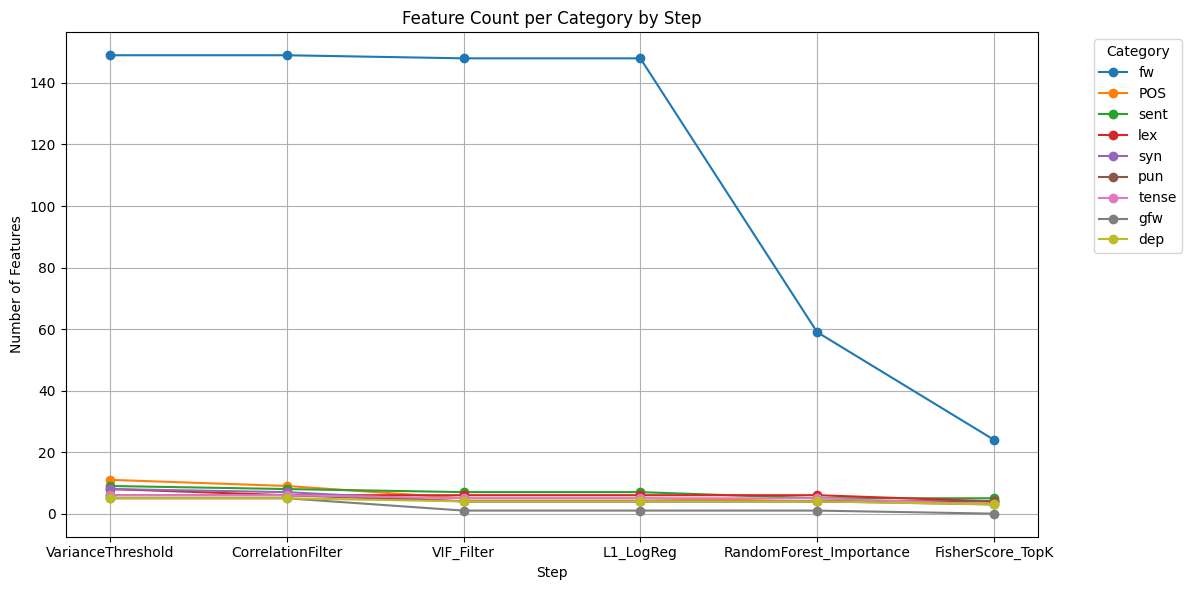

                        Step                 Feature       Score
2          CorrelationFilter         lex_Hapax_Ratio    0.976204
3          CorrelationFilter            lex_SimpsonD    0.961562
5          CorrelationFilter        sent_Exclamative    0.935958
0          CorrelationFilter                POS_PRON    0.917762
1          CorrelationFilter               POS_CCONJ    0.908813
4          CorrelationFilter        syn_NomVerbRatio    0.903047
137         FisherScore_TopK                  fw_est   33.168491
121         FisherScore_TopK                  fw_lui   33.001989
148         FisherScore_TopK                   fw_du   31.788830
130         FisherScore_TopK                   fw_le   31.706992
129         FisherScore_TopK                  fw_par   31.301242
136         FisherScore_TopK                   fw_la   30.481576
154         FisherScore_TopK                 dep_acl   30.353390
138         FisherScore_TopK                 fw_elle   30.188936
123         FisherScore_T

In [ ]:
summarize_feature_selection_logs(logs, show_dropped_table=True)

In [ ]:
def n_features_per_category(X):
    """
    Count the number of features per category based on the prefix of each column name.
    """
    categories = X.columns.str.extract(r'^([^_]+)_')[0].fillna('uncategorized')
    return categories.value_counts()

print("Number of features per category befor feature selection:")
print(n_features_per_category(X))

print("\n\nNumber of features per category after feature selection:")
print(n_features_per_category(X_temp))

Number of features per category befor feature selection:
0
fw       149
POS       11
sent       9
lex        8
syn        8
pun        6
tense      6
gfw        5
dep        5
Name: count, dtype: int64


Number of features per category after feature selection:
0
fw       24
sent      5
pun       4
lex       4
POS       4
tense     3
syn       3
dep       3
Name: count, dtype: int64


In [ ]:
features = X_temp.columns
categories = [f.split('_')[0] if '_' in f else 'uncategorized' for f in features]

df = pd.DataFrame({"Feature": features, "Category": categories})
df_sorted = df.sort_values(by="Category")
print(df_sorted)

                      Feature Category
21                    POS_AUX      POS
43                   POS_VERB      POS
6                   POS_SCONJ      POS
23                    POS_DET      POS
19                  dep_xcomp      dep
17                  dep_ccomp      dep
39                  dep_advcl      dep
48                     fw_ils       fw
26                   fw_avait       fw
27                    fw_suis       fw
30                      fw_ne       fw
31                    fw_mais       fw
0                       fw_et       fw
34                     fw_pas       fw
37                      fw_ma       fw
40                    fw_pour       fw
41                     fw_moi       fw
42                       fw_m       fw
44                    fw_même       fw
45                     fw_fut       fw
33                     fw_qui       fw
35                      fw_se       fw
24                    fw_vous       fw
20                   fw_était       fw
5                      fw

In [ ]:
X_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Data columns (total 50 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fw_et                      3858 non-null   float64
 1   pun_Semicolon_Count        3858 non-null   float64
 2   sent_AvgLength             3858 non-null   float64
 3   pun_Comma_Count            3858 non-null   float64
 4   lex_AvgWordLen             3858 non-null   float64
 5   fw_que                     3858 non-null   float64
 6   POS_SCONJ                  3858 non-null   float64
 7   fw_je                      3858 non-null   float64
 8   fw_à                       3858 non-null   float64
 9   sent_Count                 3858 non-null   float64
 10  sent_PassiveRatio          3858 non-null   float64
 11  tense_imp_ind              3858 non-null   float64
 12  fw_me                      3858 non-null   float64
 13  fw_des                     3858 non-null   float

## Training classifiers part 1 : optimization with upper bound of features

## Feature selection part 2 : optimizing for best model

Save X_final

## Training classifier part 2 : optimizing best model with best number of features

Save final model

With all features vs with selected features

In [40]:
def train_author_classifier(X, y, model_cls=LogisticRegression, model_params=None):
    if model_params is None:
        model_params = {
            "penalty": None,
            "solver": "saga",
            "multi_class": "ovr",
            "class_weight": "balanced",
            "C": 1.0,
            "max_iter": 5000
        }

    # Train/test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    # Model instantiation and training
    cls = model_cls(**model_params)
    cls.fit(X_train, y_train)

    # Predictions and evaluation
    y_pred = cls.predict(X_test)
    y_proba = cls.predict_proba(X_test) if hasattr(cls, "predict_proba") else None

    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print("F1 Macro:", f1_score(y_test, y_pred, average='macro'))
    
    if y_proba is not None:
        print("Log Loss:", log_loss(y_test, y_proba))

    # Confusion Matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    sns.heatmap(
        cm, annot=True, fmt='d',
        xticklabels=np.unique(y), yticklabels=np.unique(y), cmap="Blues"
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Coefficient inspection if available (e.g., LogisticRegression)
    if hasattr(cls, "coef_"):
        print(f"\n[Model Coefficients] Shape: {cls.coef_.shape}")
        if isinstance(X, pd.DataFrame):
            feature_names = X.columns
            coef_df = pd.DataFrame(cls.coef_, columns=feature_names)
            print("\n[Top Coefficients per Class]")
            display(coef_df.T.sort_values(by=0, ascending=False).head(10))  # first class only for brevity

    return cls, X_train, X_test, y_train, y_test

/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



--- Classification Report ---
                      precision    recall  f1-score   support

      Alain-Fournier       1.00      0.86      0.92         7
     Alexandre Dumas       0.79      0.85      0.82        40
     Alfred de Vigny       0.75      0.88      0.81        24
     Alphonse Daudet       0.78      0.84      0.81        37
      Anatole France       0.81      0.83      0.82        36
          André Gide       1.00      0.80      0.89        15
      Charles Nodier       1.00      0.75      0.86         8
    François Mauriac       0.83      0.91      0.87        11
         George Sand       0.76      0.70      0.73        40
    Georges Bernanos       0.75      0.75      0.75        12
    Gustave Flaubert       0.82      0.89      0.86        37
   Guy de Maupassant       0.74      0.77      0.75        26
      Henri Barbusse       0.93      0.93      0.93        15
    Honoré de Balzac       0.92      0.87      0.89        39
        Jules Renard       0.88      0

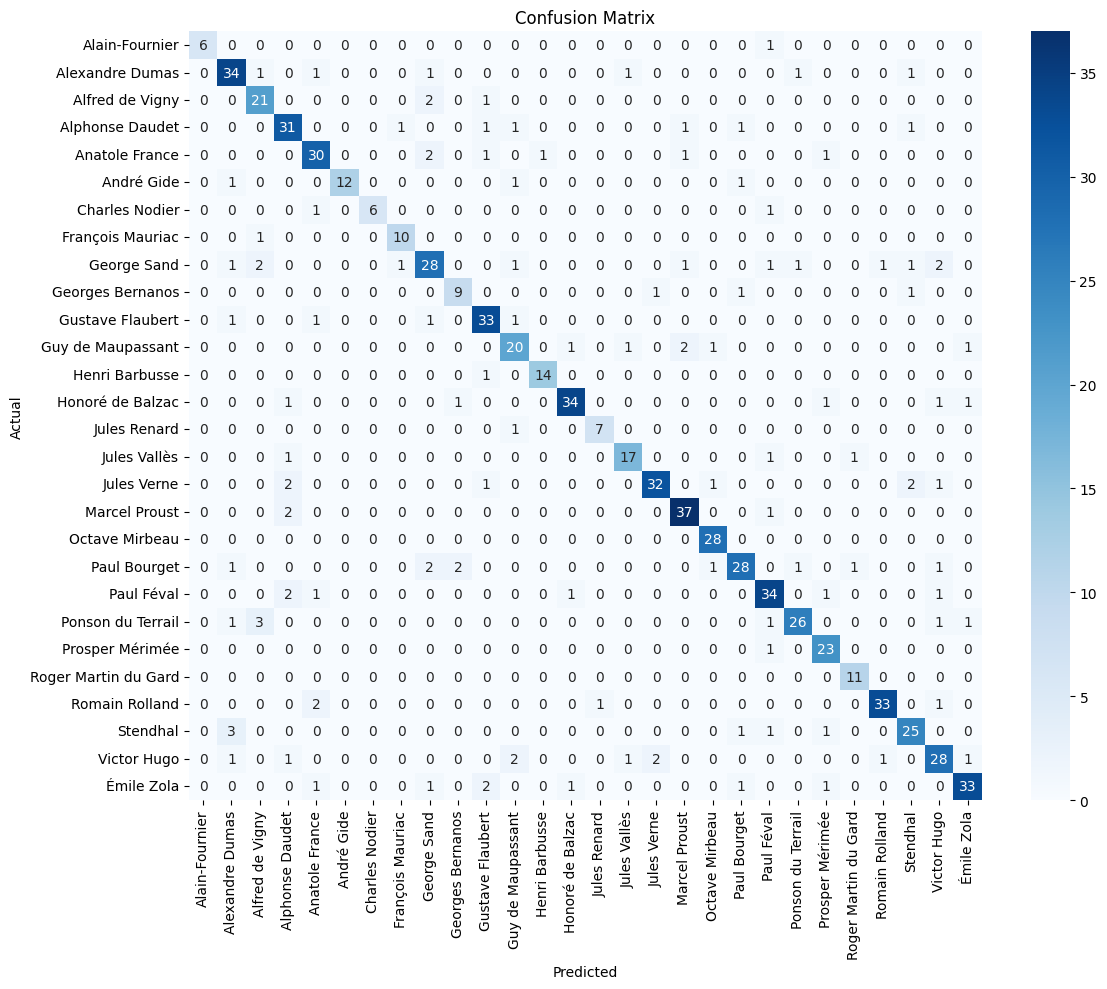


[Model Coefficients] Shape: (28, 207)

[Top Coefficients per Class]


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
fw_la,1.462855,1.607798,0.068850,0.086579,2.713234,0.625721,-0.649516,-0.143610,2.096054,0.403558,...,0.043119,-0.545411,1.294369,0.176242,0.144033,-0.051181,0.876383,0.060112,2.340253,0.956011
POS_ADP,1.429791,-2.462898,0.322595,-1.029130,-1.057239,0.403899,0.987841,0.104651,-0.607546,1.018638,...,-0.621495,-0.518351,-0.637352,-1.786485,-0.396564,0.465788,0.738503,0.562260,-0.171875,0.078226
fw_sur,1.170389,0.469049,-0.118354,-0.128528,0.228991,0.473305,0.276649,0.022865,0.338310,-0.030325,...,-0.060151,0.598846,-1.058371,-0.356796,0.221547,0.416565,-1.073652,0.074290,-0.831915,-0.699247
fw_avait,1.030513,0.961436,-0.341765,-1.220316,-0.604121,-0.006720,-0.295014,0.025665,-0.484651,-0.316873,...,0.032737,0.335504,2.465831,1.089357,-0.187481,-0.260821,-0.608410,-0.749217,0.962853,0.179357
fw_je,0.983917,-1.803488,0.644075,-0.989813,0.789632,-0.292014,0.107316,-0.934623,1.687266,0.070140,...,0.718190,-0.230982,-0.192714,-1.698168,0.947687,0.144409,1.152988,-0.125225,-1.670413,-0.368074
POS_VERB,0.806347,-1.733542,0.250288,-0.430891,-0.931185,0.492736,0.237191,0.454933,0.526984,-0.396692,...,0.506035,-2.522941,0.882365,1.690379,1.688039,-0.098085,0.086344,-0.324472,-0.924237,-0.135429
fw_sont,0.781286,-1.123765,-0.159377,-0.684404,-0.367238,-0.387983,-0.359030,-0.247899,-0.062722,-0.088873,...,0.399268,-0.055021,-0.009674,-0.522613,0.529759,-0.027615,0.002841,0.137809,-0.918773,0.300879
tense_inf,0.727707,-0.447467,0.002647,1.134413,-0.705914,-0.528097,-0.997236,-0.148168,1.575173,-0.547093,...,0.242552,0.428544,-0.671383,-0.104853,-1.860096,0.737914,0.146788,1.692043,0.626248,-0.059128
dep_mark,0.697720,0.642080,-1.399262,0.172979,2.167858,-0.217088,1.333735,0.378359,0.026846,-0.293616,...,-0.291137,0.523961,-1.456163,-2.409801,2.407113,-0.004489,2.650848,-0.416689,-2.026647,-0.317096
fw_dans,0.696339,-1.157968,-0.518525,-0.386624,0.568050,-0.182601,-0.189587,0.365782,1.581973,0.105845,...,0.544005,-0.370878,-1.052408,-0.832982,0.014825,-0.430040,-0.103761,0.487503,0.073629,-0.617031


In [48]:
clf, X_train, X_test, y_train, y_test = train_author_classifier(X, y)

/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



--- Classification Report ---
                      precision    recall  f1-score   support

      Alain-Fournier       0.50      0.43      0.46         7
     Alexandre Dumas       0.87      0.82      0.85        40
     Alfred de Vigny       0.60      0.88      0.71        24
     Alphonse Daudet       0.78      0.86      0.82        37
      Anatole France       0.72      0.72      0.72        36
          André Gide       0.93      0.87      0.90        15
      Charles Nodier       0.56      0.62      0.59         8
    François Mauriac       0.47      0.82      0.60        11
         George Sand       0.85      0.70      0.77        40
    Georges Bernanos       1.00      0.67      0.80        12
    Gustave Flaubert       0.89      0.89      0.89        37
   Guy de Maupassant       0.63      0.65      0.64        26
      Henri Barbusse       1.00      1.00      1.00        15
    Honoré de Balzac       0.85      0.90      0.88        39
        Jules Renard       1.00      1

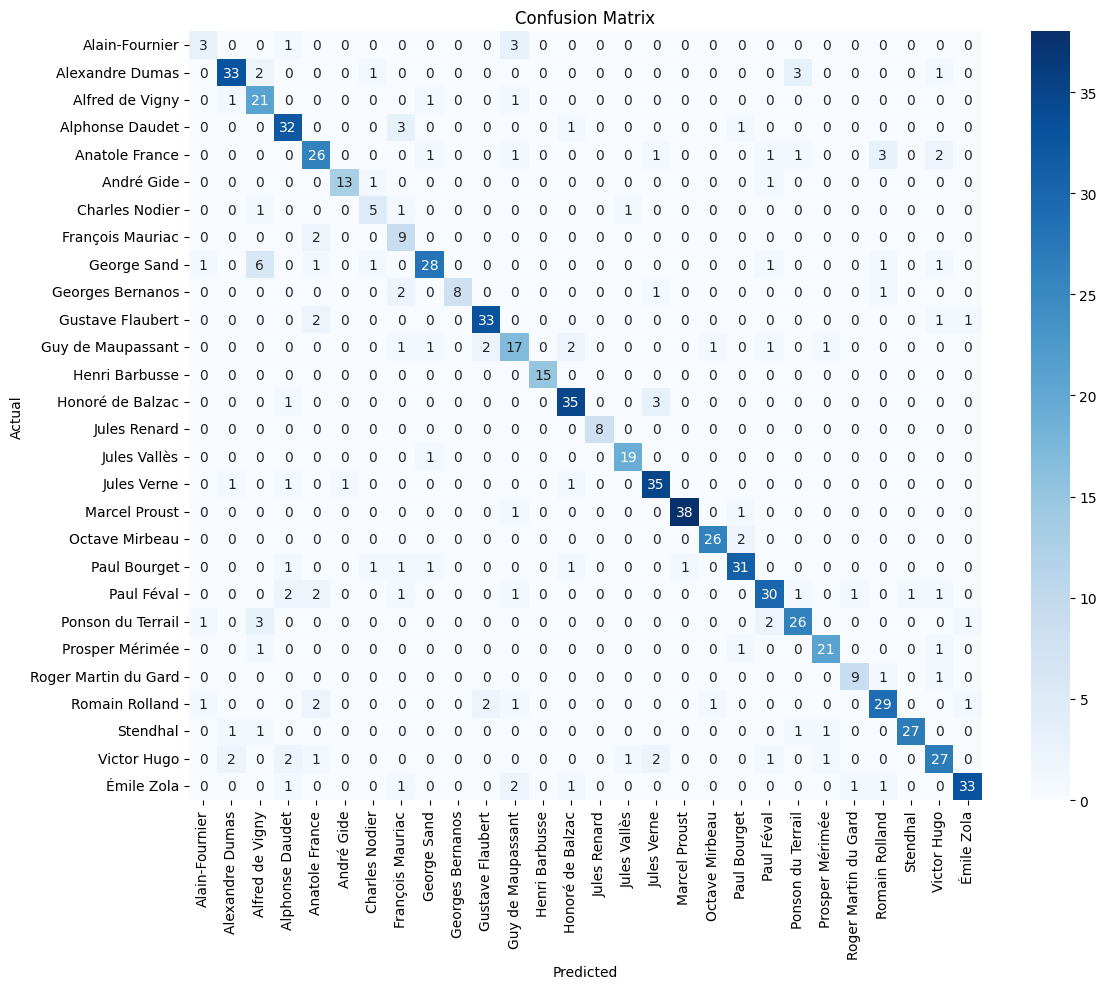


[Model Coefficients] Shape: (28, 50)

[Top Coefficients per Class]


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
fw_je,4.629776,-0.352300,1.279371,-0.883104,0.087742,0.803766,3.428676,-4.629356,0.160465,-1.067650,...,2.208739,1.731482,0.613700,-1.521142,0.108889,1.346959,0.674131,-1.356136,-1.167323,-1.272047
POS_VERB,3.952670,-1.013293,1.077316,-1.225893,-1.657664,3.035381,-0.894643,4.504051,-0.819887,1.221487,...,3.807427,-1.902001,-0.564120,1.527872,1.749550,2.061993,-0.893626,-1.663815,-0.786882,1.945622
lex_Entropy,3.381682,0.086542,1.324573,2.049577,2.977522,1.284604,4.542774,3.852047,0.924203,4.663659,...,1.068780,2.924537,4.424892,3.389015,1.640253,2.114566,-0.995049,3.488726,0.810119,-0.255926
tense_imp_ind,2.680900,-1.009884,-0.762709,0.853408,0.814080,1.784072,-0.795399,3.107997,-1.384322,-1.555273,...,0.948023,0.029349,-0.368446,-1.495068,-1.136252,-6.880408,-0.342554,0.770590,0.418498,2.656526
tense_inf,2.205298,0.087205,0.470142,0.979655,0.218631,-0.845229,-1.594800,-1.423789,1.718477,-0.745199,...,-0.076022,-0.053962,-0.713827,-0.787382,-1.287198,0.448609,0.666726,2.457211,0.427155,0.512527
POS_DET,1.405090,-0.597062,-0.315062,-0.409867,0.444978,0.328712,0.405248,0.130939,-0.685948,2.344166,...,1.282941,0.909529,0.050973,0.587108,0.685551,3.262765,-0.131516,-1.275519,1.384304,1.207462
POS_AUX,1.272533,-0.055728,-0.553438,-1.476248,0.365235,0.726730,2.803429,0.719574,0.896391,-1.043519,...,1.529411,0.732071,-0.784813,-0.667439,-1.000295,1.725460,-0.586322,-1.238352,2.131355,2.955967
syn_AdjNounRatio,1.162451,-1.210984,-0.004422,0.244759,-0.115950,0.354731,-1.274670,-0.371711,0.633669,1.387108,...,0.501984,-0.242208,-0.111741,-0.283932,-1.785922,0.774067,1.362439,-0.247264,-0.490013,0.499406
fw_moi,1.076828,0.367024,-0.346539,0.093840,-1.849903,-0.768075,-0.235482,0.688367,0.554679,-0.290685,...,0.536858,0.049229,0.445388,0.425225,-1.587125,-0.455642,0.391958,1.166432,-0.237036,-0.718916
fw_mais,1.071393,0.325345,-0.594429,0.469244,-0.027116,0.176852,-0.254175,0.537480,0.272236,1.328756,...,-2.311546,-0.567374,0.641432,0.191722,0.052717,-0.654097,0.741416,0.524063,-2.491418,-1.583227


In [49]:
clf, X_train, X_test, y_train, y_test = train_author_classifier(X_final, y)